# Waveform denoised and reconstructed on DownSampled data

*author: Elena Cuoco*

**We want to show you how a gravitational wave signal becomes more apparent after whitening and double whitening of the data.**

In [1]:
import time
import os
from pytsa.tsa import *
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import *
from wdf.processes.DownSampling import *
from wdf.processes.Whitening import  *
from wdf.processes.DWhitening import  *
import logging, sys
 
logger = logging.getLogger()
logger.setLevel(logging.INFO)
 

new_json_config_file = True    # set to True if you want to create new Configuration

 
     
if new_json_config_file==True:
    configuration = {
      "file": "./data/test.gwf",
      "channel": "H1:GWOSC-4KHZ_R1_STRAIN", 
      "len":2.0,
      "gps":1167559536,
      "outdir": "./",
      "dir":"./", 
      "ARorder": 1000,
      "learn": 100,
      "preWhite":4,
      "ResamplingFactor":2,
    }

filejson = os.path.join(os.getcwd(),"WavRecDS.json")
file_json = open(filejson, "w+")
json.dump(configuration, file_json)
file_json.close()

logging.info("read parameters from JSON file")
 
par = Parameters()
filejson = "WavRecDS.json"
try:
    par.load(filejson)
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()
    
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
par.resampling=par.sampling/par.ResamplingFactor
 
logging.info("channel= %s at sampling frequency= %s" %(par.channel, par.resampling))
whiten=Whitening(par.ARorder)

par.ARfile = "./ARcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.resampling, par.channel)
par.LVfile ="./LVcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.resampling, par.channel)

if os.path.isfile(par.ARfile) and os.path.isfile(par.LVfile):
        logging.info('Load AR parameters')
        whiten.ParametersLoad(par.ARfile, par.LVfile)
else:
        logging.info('Start AR parameter estimation')
        ######## read data for AR estimation###############
        strLearn = FrameIChannel(
                    par.file, par.channel, par.learn, par.gps
                )
        Learn = SV()
        Learn_DS = SV()
        par.Noutdata = int(par.learn *par.resampling)
        ds = DownSampling(par,estimation=True)
        strLearn.GetData(Learn)
        Learn_DS=ds.Process(Learn)
        whiten.ParametersEstimate(Learn_DS)
        whiten.ParametersSave(par.ARfile, par.LVfile)
        del Learn, ds, strLearn, Learn_DS

INFO:root:read parameters from JSON file
INFO:root:channel= H1:GWOSC-4KHZ_R1_STRAIN at sampling frequency= 2048.0
INFO:root:Start AR parameter estimation
INFO:root:Padlen not defined, we fix it equal to int(fs/4)
INFO:root:Estimation status not fixed, the default is False. If you need to estimate AR, please fix it


In [2]:
# sigma for the noise
par.sigma = whiten.GetSigma()
print('Estimated sigma= %s' % par.sigma)

Estimated sigma= 4.075084250279407e-22


We use some chunck of data to pre-heating the whitening procedure and avoiding the filter tail.

In [3]:
lenS=par.len
N=int(par.resampling*lenS)
padlen=int(par.sampling/4)
par.Noutdata=N
par.len=lenS
gpsEvent=1167559936.6
gps=gpsEvent-1.0-(par.preWhite)*lenS +padlen/par.sampling
ds = DownSampling(par,padlen=padlen)
Dwhiten=DWhitening(whiten.LV,N,0)
streaming = FrameIChannel(par.file, par.channel, lenS, gps)

#Try to center 1sec beore and 1 after the event


data = SV()
dataw = SV()
dataww = SV()


 

###---whitening preheating---###
for i in range(par.preWhite):
    streaming.GetData(data)
    data_ds=ds.Process(data)
    whiten.Process(data_ds, dataw)
    Dwhiten.Process(data_ds, dataww) 

INFO:root:Estimation status not fixed, the default is False. If you need to estimate AR, please fix it


In [4]:
print(par.file, par.channel, lenS, gps,dataw.GetStart(),dataw.GetStart(),dataw.GetSize()/par.resampling)

./data/test.gwf H1:GWOSC-4KHZ_R1_STRAIN 2.0 1167559927.85 1167559933.6 1167559933.6 2.0


In [5]:
streaming.GetData(data)
data_ds=ds.Process(data)
whiten.Process(data_ds, dataw)
Dwhiten.Process(data_ds, dataww)

## Plot: raw and whitened data

### time-domain

In [6]:
 
import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab
import os
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (15.0, 10.0)
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)
 
x=np.zeros(dataw.GetSize())
y=np.zeros(dataw.GetSize())
yw=np.zeros(dataw.GetSize())
yww=np.zeros(dataww.GetSize())
for i in range(dataw.GetSize()):
    x[i]=data_ds.GetX(i)
    y[i]=data_ds.GetY(0,i)
    yw[i]=dataw.GetY(0,i)
    yww[i]=dataww.GetY(0,i)




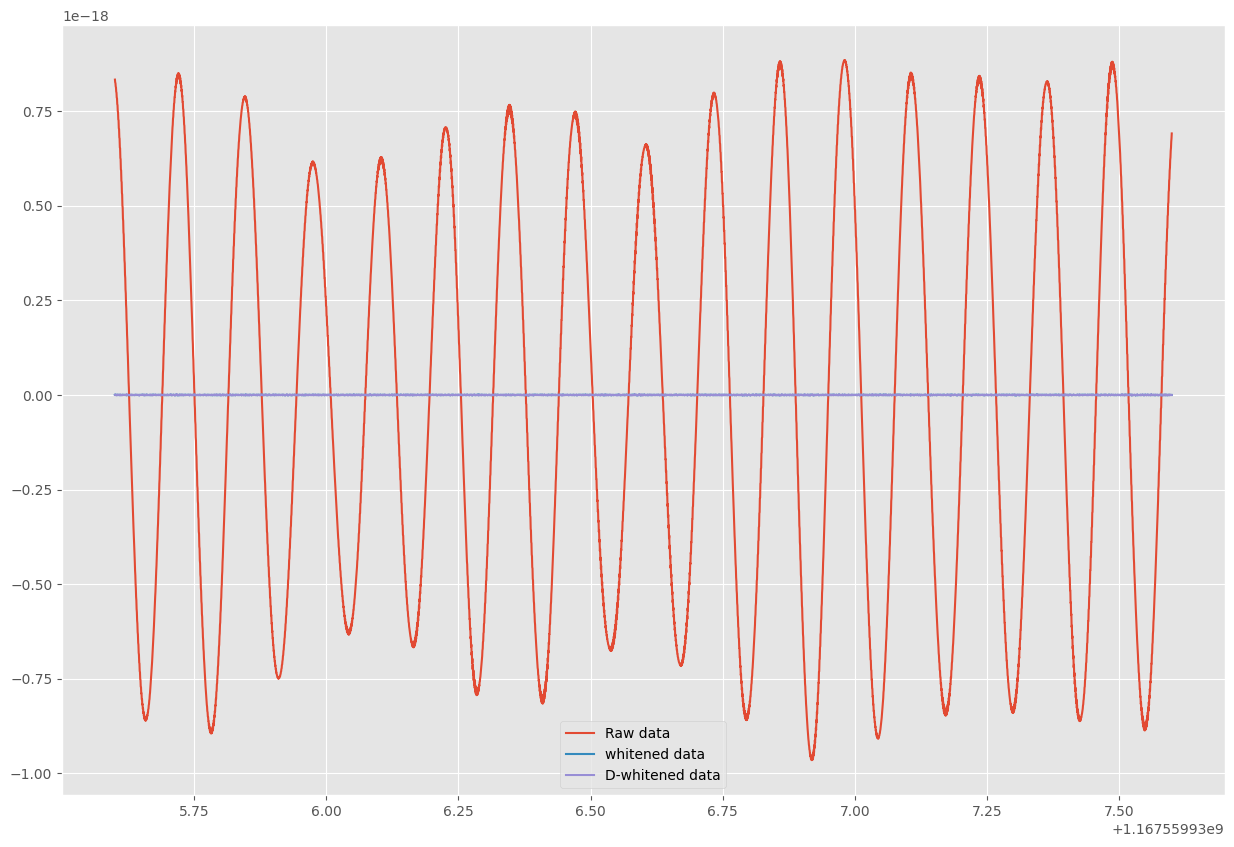

In [7]:
fig, ax = plt.subplots()

ax.plot(x, y,  label='Raw data')
ax.plot(x, yw, label='whitened data')
ax.plot(x, yww, label='D-whitened data')
ax.legend()
plt.show()
    

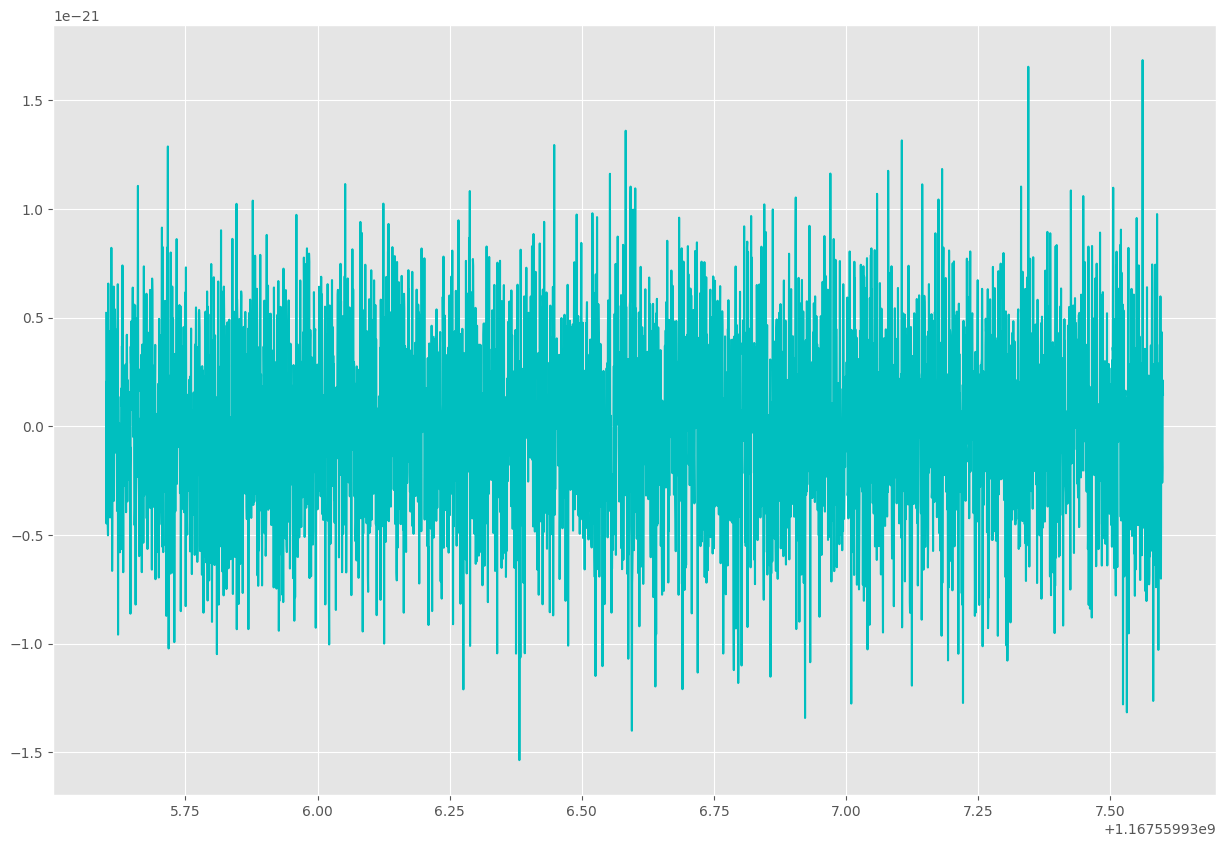

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
#ax.plot(x, yww, 'gray',label='D-whitened data')
ax.plot(x, yw, 'c',label='whitened data')


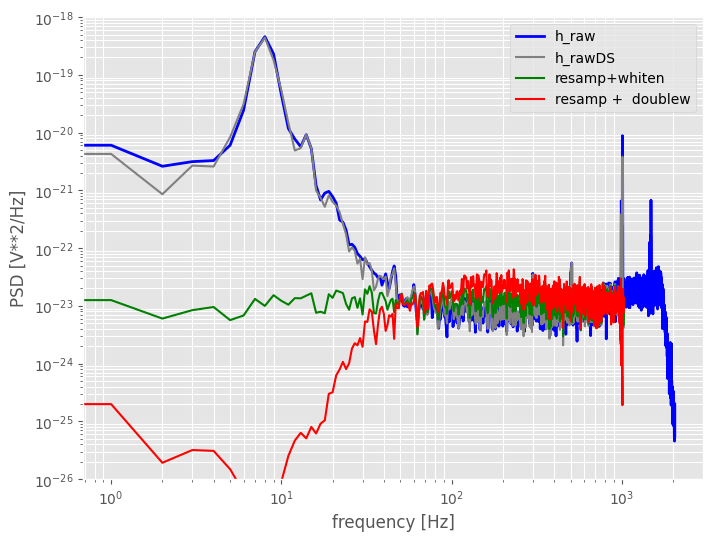

In [9]:
from scipy import signal
%matplotlib inline
xraw=np.zeros(data.GetSize())
yraw=np.zeros(data.GetSize())
for i in range(data.GetSize()):
    xraw[i]=data.GetX(i)
    yraw[i]=data.GetY(0,i)
fs=par.sampling
frs=par.resampling
fraw, Pxx_denraw = signal.welch(yraw, par.sampling, nperseg=fs)
f, Pxx_den = signal.welch(y, par.resampling, nperseg=frs)
fds, Pxx_denDS = signal.welch(yw, par.resampling, nperseg=frs)
fw, Pxx_denW= signal.welch(yww, par.resampling, nperseg=frs)
fig, ax = plt.subplots(figsize=(8,6))
ax.loglog(fraw, np.sqrt(Pxx_denraw),'b', label = 'h_raw', linewidth=2)
ax.loglog(f, np.sqrt(Pxx_den),'gray', label = 'h_rawDS')
ax.loglog(fds, np.sqrt(Pxx_denDS),'g', label='resamp+whiten') 
ax.loglog(fw, np.sqrt(Pxx_denW),'r', label='resamp +  doublew') 
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(), plt.ylim(1e-26, 1e-18), plt.grid(which='both');

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
from matplotlib.colors import LogNorm

def prepareImage_gw(x,y,fs,title="Time-Freqeuncy map"):
    w = 10.
    freq = np.linspace(1, fs/2, int(fs/2))
    widths = w*fs / (2*freq*np.pi)
    z = np.abs(signal.cwt(y, signal.morlet2, widths, w=w))**2

    plt.pcolormesh(x, freq,z,cmap='coolwarm',shading='gouraud',alpha=0.95)
    plt.yscale('log')
    plt.ylim(4, 1000)
    plt.title=title
    plt.show() 
   
    return 

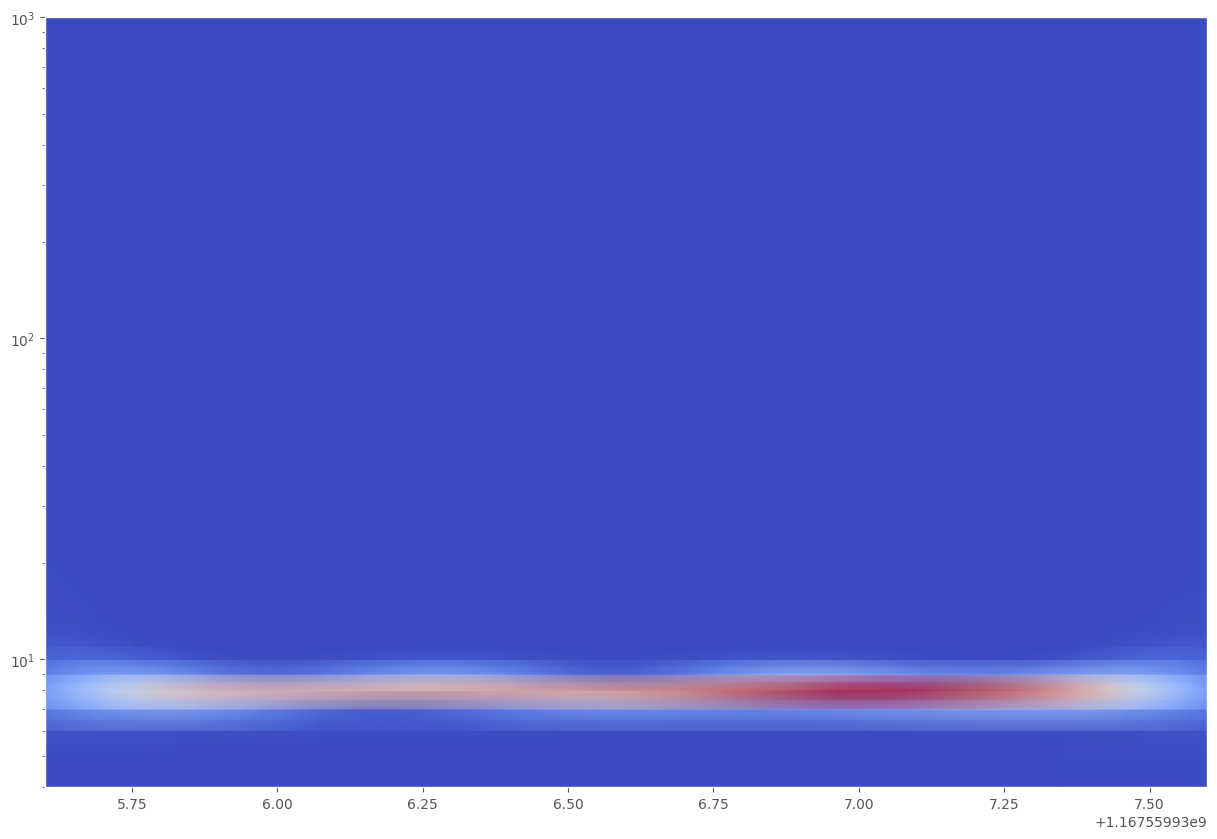

In [11]:
prepareImage_gw(x,y,par.resampling)

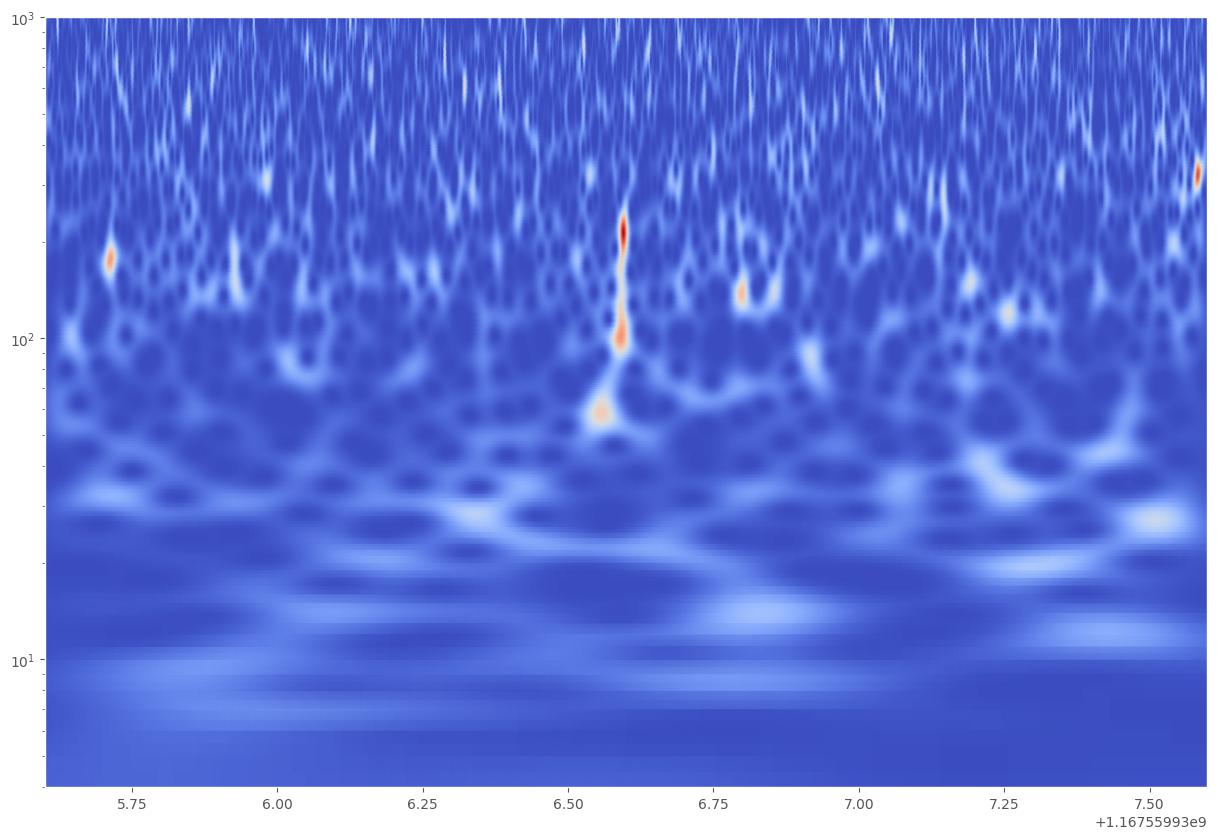

In [12]:
prepareImage_gw(x,yw,par.resampling)

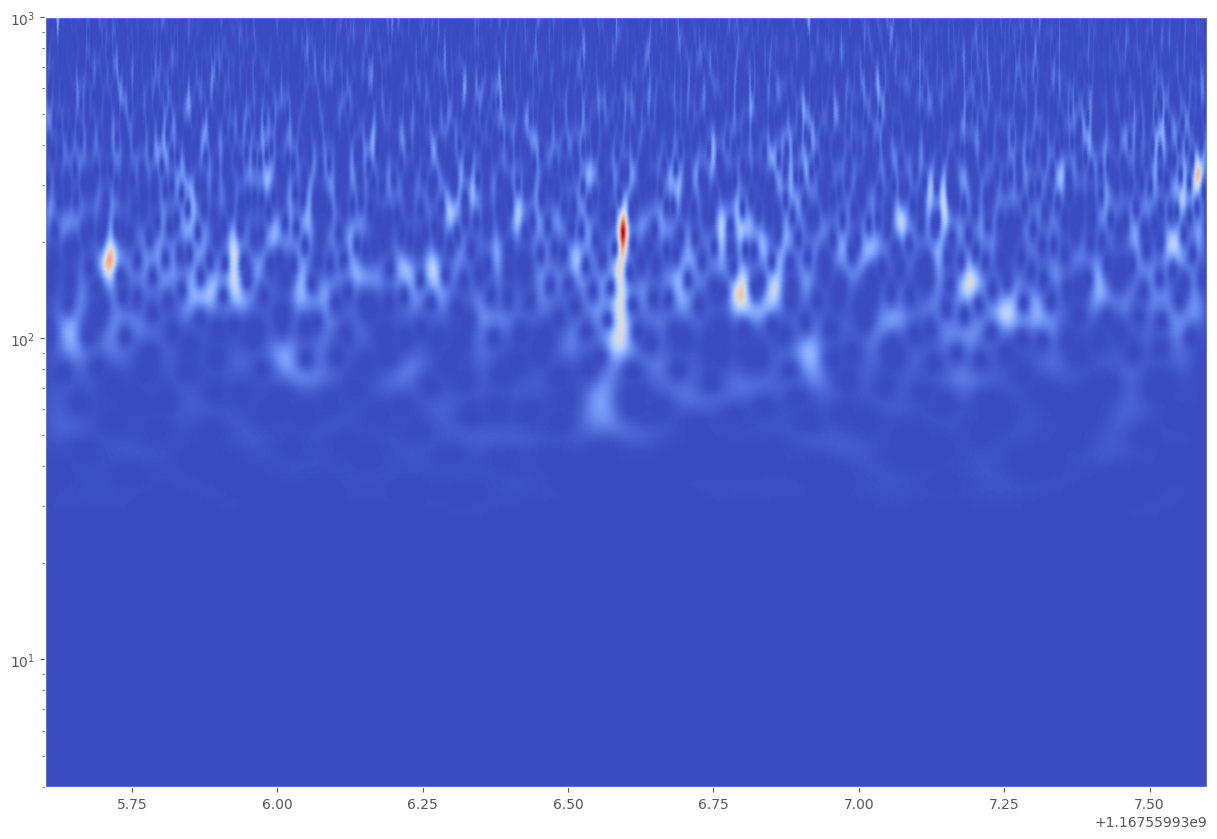

In [13]:
prepareImage_gw(x,yww,par.resampling)

In [14]:
datasize=dataw.GetSize()
yr=np.zeros(dataw.GetSize())
sigma=whiten.GetSigma()

wt = WaveletTransform.DaubC20
WT = WaveletTransform(datasize, wt)
t = WaveletThreshold.dohonojohnston
wavthres = WaveletThreshold(datasize, 1, sigma);
 
WT.Forward(dataww);
wavthres(dataww, t);
WT.Inverse(dataww);
for i in range(len(yr)):
    yr[i]=dataww.GetY(0,i)


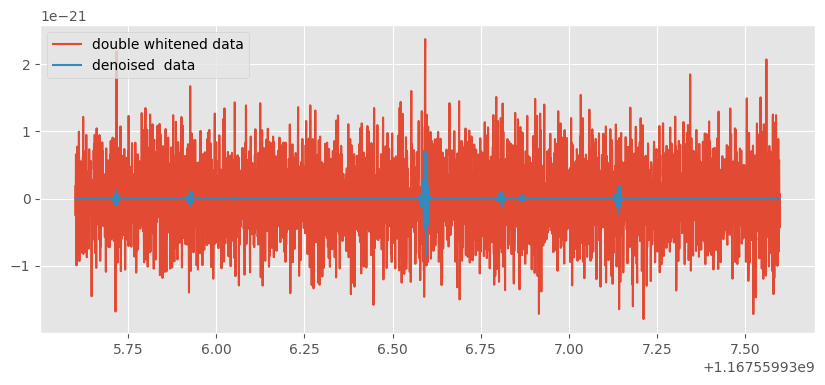

In [15]:

#%matplotlib notebook
plt.figure(figsize=(10,4)),
plt.plot(x, yww,  label='double whitened data')
plt.plot(x, yr, label='denoised  data')

plt.legend()
plt.show()


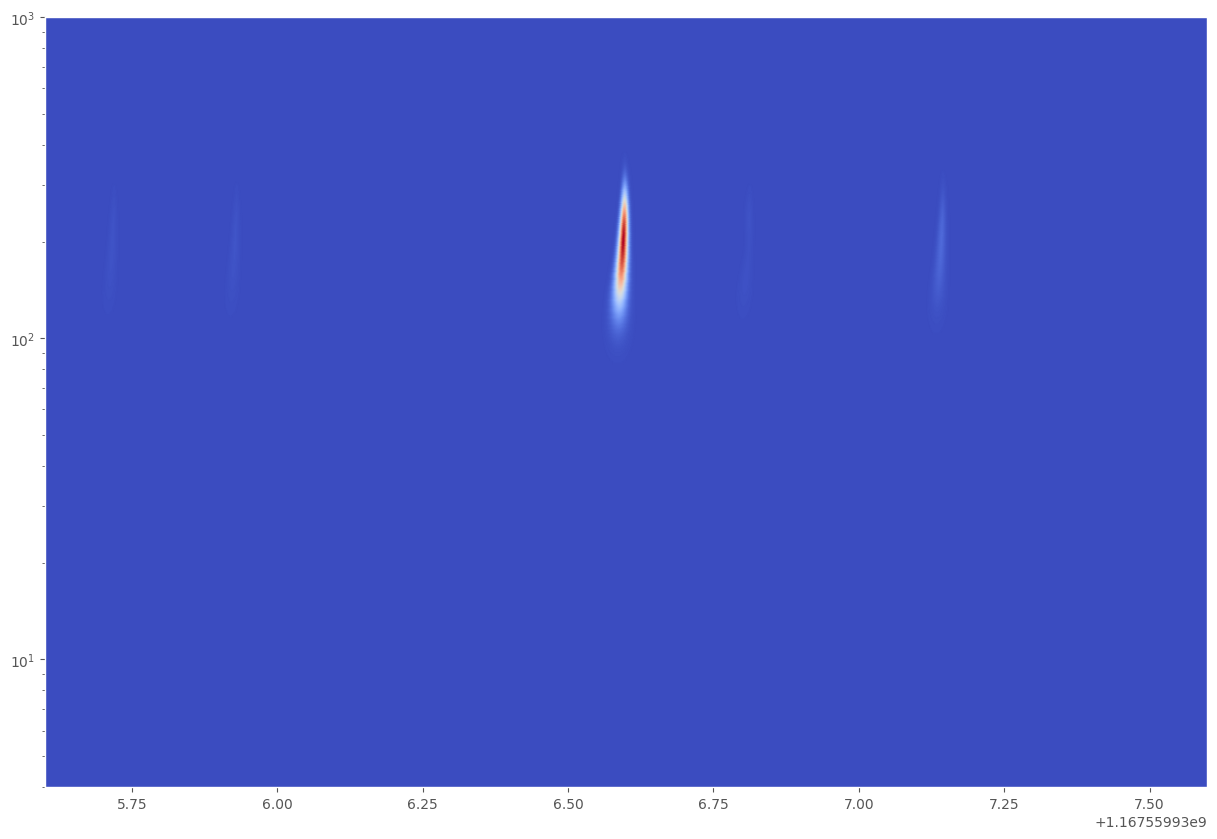

In [16]:
prepareImage_gw(x,yr,par.resampling)